# Predicting Lenght Of Stay at the ICU using Machine Learning

## **Introduction**  

This work focuses on predicting ICU length of stay (LOS) using the **MIMIC-III** dataset, a large-scale collection of electronic health records from over 26,000 ICU patients. The dataset includes diverse clinical variables such as vital signs, lab results, and treatment records, presenting both temporal and high-dimensional challenges. Given the volume and complexity of the data, we employ scalable machine learning techniques to preprocess, model, and interpret predictive patterns. The analysis aims to assist in resource allocation and clinical decision-making while addressing computational constraints inherent in big healthcare data.

Given the dataset's size, traditional single-node tools (e.g., Pandas, Scikit-learn) would be inefficient due to memory and computational limitations. Instead, we leverage **PySpark**  for both Data Processing and Machine Learning.

1. **Scalability** – PySpark efficiently processes large datasets by distributing computations across a cluster, making it ideal for big data workloads.  
2. **In-Memory Processing** – Spark's in-memory execution significantly speeds up iterative operations, crucial for machine learning pipelines.  
3. **Integration with MLlib** – PySpark provides MLlib, a scalable machine learning library that supports preprocessing, feature engineering, and model training on distributed datasets.  
4. **Fault Tolerance & Optimization** – Spark’s lazy evaluation and DAG-based execution optimize performance, while its fault-tolerant design ensures reliability.  
5. **Compatibility with Big Data Ecosystems** – PySpark integrates seamlessly with storage systems (HDFS, S3) and SQL-based tools (Spark SQL), facilitating efficient data handling.  


Our analysis follows a structured machine learning pipeline:  

1. **Load Data & Initialize Session** - Get the data from the Google Cloud Storage.
2. **Exploratory Data Analysis** - Statiscial overview of the data.
3. **Feature Engineering** – Aggregating patient records over a chosen window size to balance predictive power and computational feasibility.  
4. **Data Preprocessing** – Handling missing values, encoding categorical variables, and normalizing features using PySpark’s DataFrame API. 
5. **Model Training & Validation** – Employing distributed ML algorithms via MLlib, with hyperparameter tuning using Cross Validaton.  
6. **Performance Profiling** – Monitoring execution time and resource usage to identify bottlenecks.  
7. **Interpretation of Results** – Evaluating model performance using metrics, discussing feature importance and justifying the chosen window size.  

By leveraging **PySpark**, we ensure that our pipeline is both scalable and efficient, enabling robust analysis of ICU patient data while maintaining computational feasibility. The following sections detail our approach, results, and key insights.

## **1.** Load Data & Initialize Session

Import needed libraries:
* Pyspark SQL
* Pyspark ML feature, functions, regression, evaluation and tuning
* Datatime and Time
* 
* OS, SYS and warnings


In [1]:
# =============================================
# 📦 PYSPARK CORE & DATAFRAME OPERATIONS
# =============================================
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql.functions import (
    col,    lit,    sum as sql_sum,    count,    mean,    stddev,    min,    max,
    percentile_approx,    when,    coalesce,    isnull,    datediff,    row_number,
    first,    broadcast,    floor,    udf,    expr
)


# =============================================
# 🔧 DATA PROCESSING & FEATURE ENGINEERING
# =============================================
from pyspark.ml.feature import (
    VectorAssembler,
    StandardScaler,
    StringIndexer,
    MinMaxScaler,
    Imputer,
    Bucketizer
)
from pyspark.ml.functions import vector_to_array


# =============================================
# 🤖 MACHINE LEARNING MODELS
# =============================================
from pyspark.ml.regression import (
    RandomForestRegressor,
    LinearRegression,
    GBTRegressor
)


# =============================================
# 📊 MODEL EVALUATION & HYPERPARAMETER TUNING
# =============================================
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    BinaryClassificationEvaluator
)
from pyspark.ml.tuning import (
    CrossValidator, 
    ParamGridBuilder
)
from pyspark.ml import Pipeline


# =============================================
# 🛠️ UTILITY LIBRARIES
# =============================================
from datetime import datetime, timedelta
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# =============================================
# ⚙️ SYSTEM CONFIGURATION
# =============================================
import os
import sys
import warnings
warnings.filterwarnings('ignore')


print("\n✅ All imports loaded successfully!")
print(f"⏰ Notebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"🔥 Spark version: {SparkSession.builder.getOrCreate().version}\n")


✅ All imports loaded successfully!
⏰ Notebook started at: 2025-06-07 19:05:48
🐍 Python version: 3.10.12


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/07 19:05:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


🔥 Spark version: 4.0.0



Initialize spark session.

In [2]:
spark = SparkSession.builder \
    .appName("Forecast-LOS") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    \
    .config("spark.executor.memory", "5g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    \
    .config("spark.driver.memory", "10g") \
    .config("spark.driver.cores", "3") \
    .config("spark.driver.maxResultSize", "2g") \
    \
    .config("spark.sql.shuffle.partitions", "32") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "64MB") \
    .config("spark.sql.files.maxPartitionBytes", "128MB") \
    .config("spark.sql.adaptive.maxShuffledHashJoinLocalMapThreshold", "32MB") \
    \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.broadcastTimeout", "300s") \
    .config("spark.rpc.askTimeout", "300s") \
    \
    .config("spark.executor.heartbeatInterval", "20s") \
    .config("spark.dynamicAllocation.enabled", "false") \
    \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.adaptive.localShuffleReader.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes", "128MB") \
    \
    .config("spark.executor.memoryOffHeap.enabled", "true") \
    .config("spark.executor.memoryOffHeap.size", "1g") \
    \
    .getOrCreate()
print("✅ Spark session created successfully!")
print(f"📊 Spark Version: {spark.version}")
print(f"🔧 Application Name: {spark.sparkContext.appName}")
print(f"💾 Available cores: {spark.sparkContext.defaultParallelism}")
print(f"\n⏰ Spark session initialised at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Spark session created successfully!
📊 Spark Version: 4.0.0
🔧 Application Name: pyspark-shell
💾 Available cores: 8

⏰ Spark session initialised at: 2025-06-07 19:05:52


25/06/07 19:05:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Load and prepare the MIMIC-III dataset for analysis in a Spark environment. It first configures data path, then loads ICU stay records and filters related clinical data (vitals, lab results, diagnoses, and demographics) to only include patients with ICU stays.  

**Optimizations:** The script improves performance by caching frequently used ICU stay data, using broadcast joins for efficient table merging, and converting CSV files to parquet format for faster reads. It also supports sampling for smaller test datasets.  

Finally, report row counts for key tables, including filtered ICU stays, patient records, admissions, diagnoses, measurements, and lab results.

In [ ]:
MIMIC_PATH = "gs://dataproc-staging-europe-west2-851143487985-hir6gfre/mimic-data"

print("🏥 Loading MIMIC-III data...")

print("📂 Loading CHARTEVENTS...")

try:
   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   print("✅ Loaded CHARTEVENTS from parquet")
except:
   print("📄 Converting CHARTEVENTS.csv.gz to parquet...")
   chartevents_csv = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/CHARTEVENTS.csv.gz")
   chartevents_csv.write.mode("overwrite").parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")
   print("✅ Converted and loaded CHARTEVENTS")


print("\n📂 Loading and filtering ICUSTAYS...")
icustays_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ICUSTAYS.csv.gz")

icustays_df.cache()
actual_sample_size = icustays_df.count()

   
print("📋 Creating ID lookup tables...")
icu_lookup = icustays_df.select("ICUSTAY_ID").distinct().cache()
hadm_lookup = icustays_df.select("HADM_ID").distinct().cache()
subject_lookup = icustays_df.select("SUBJECT_ID").distinct().cache()

icu_lookup.count()  
hadm_lookup.count()
subject_lookup.count()


print("📂 Loading PATIENTS table...")
patients_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/PATIENTS.csv.gz")
patients_df = patients_df.join(broadcast(subject_lookup), "SUBJECT_ID", "inner")

print("📂 Loading ADMISSIONS table...")
admissions_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ADMISSIONS.csv.gz")
admissions_df = admissions_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")

print("📂 Loading DIAGNOSES_ICD table...")
diagnoses_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/DIAGNOSES_ICD.csv.gz")
diagnoses_df = diagnoses_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")
d_items_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/D_ITEMS.csv.gz")


print("📂 Loading CHARTEVENTS table... [FILTERING BY ICUSTAY_ID]")
chartevents_df = chartevents_df \
   .select("ICUSTAY_ID", "CHARTTIME", "ITEMID", "VALUE", "VALUEUOM", "VALUENUM") \
   .join(broadcast(icu_lookup), "ICUSTAY_ID", "inner")


print("📂 Loading LABEVENTS table... [FILTERING BY HADM_ID]")
try:
   labevents_df = spark.read.parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")
except:
   print("📄 Converting LABEVENTS.csv.gz to parquet...")
   labevents_csv = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/LABEVENTS.csv.gz")
   labevents_csv.write.mode("overwrite").parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")
   labevents_df = spark.read.parquet(f"{MIMIC_PATH}/LABEVENTS.parquet")

d_labitems_df = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/D_LABITEMS.csv.gz")
labevents_df = labevents_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")

print("\n✅ Data loading complete!")
print(f"📊 ICUSTAYS: {icustays_df.count():,} rows")
print(f"📊 PATIENTS: {patients_df.count():,} rows") 
print(f"📊 ADMISSIONS: {admissions_df.count():,} rows")
print(f"📊 DIAGNOSES_ICD: {diagnoses_df.count():,} rows")
print(f"📊 CHARTEVENTS (filtered): {chartevents_df.count():,} rows")
print(f"📊 LABEVENTS (filtered): {labevents_df.count():,} rows")
print(f"\n⏰ Data loaded at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

'MIMIC_PATH = "gs://dataproc-staging-europe-west2-851143487985-hir6gfre/mimic-data"\n\nprint("🏥 Loading MIMIC-III data...")\n\nprint("📂 Loading CHARTEVENTS...")\n\ntry:\n   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")\n   print("✅ Loaded CHARTEVENTS from parquet")\nexcept:\n   print("📄 Converting CHARTEVENTS.csv.gz to parquet...")\n   chartevents_csv = spark.read.option("header", "true").option("inferSchema", "false").csv(f"{MIMIC_PATH}/CHARTEVENTS.csv.gz")\n   chartevents_csv.write.mode("overwrite").parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")\n   chartevents_df = spark.read.parquet(f"{MIMIC_PATH}/CHARTEVENTS.parquet")\n   print("✅ Converted and loaded CHARTEVENTS")\n\n\nprint("\n📂 Loading and filtering ICUSTAYS...")\nicustays_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ICUSTAYS.csv.gz")\n\nicustays_df.cache()\nactual_sample_size = icustays_df.count()\n\n   \nprint("📋 Creating ID lookup tables...")\nicu_lookup =

In [ ]:
"""
SAMPLE_ENABLE = False
SAMPLE_SIZE = 20000
MIMIC_PATH = "mimic-db-short"
print("🏥 Loading MIMIC-III data...")
# Step 1: First, find ICUSTAY_IDs that have ALL required vital signs
print("📂 Loading CHARTEVENTS...")
chartevents_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/CHARTEVENTS.csv")
d_items_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/D_ITEMS.csv")
print("✅ Loaded CHARTEVENTS from parquet")
# Step 2: Load ICUSTAYS 
print("\n📂 Loading and filtering ICUSTAYS...")
icustays_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ICUSTAYS.csv")
# Step 3: Apply sampling if enabled
if SAMPLE_ENABLE:
    print(f"🎯 Sampling {SAMPLE_SIZE} ICU stays...")
    icustays_df = icustays_df.limit(SAMPLE_SIZE)
    icustays_df.cache()
    actual_sample_size = icustays_df.count()
    print(f"✅ Final sample: {actual_sample_size} ICU stays")
else:
    icustays_df.cache()
    actual_sample_size = icustays_df.count()
   
   
# Step 4: Create efficient lookup tables
print("📋 Creating ID lookup tables...")
icu_lookup = icustays_df.select("ICUSTAY_ID").distinct().cache()
hadm_lookup = icustays_df.select("HADM_ID").distinct().cache()
subject_lookup = icustays_df.select("SUBJECT_ID").distinct().cache()
icu_lookup.count()  # Trigger caching
hadm_lookup.count()
subject_lookup.count()
# Step 5: Load other tables with optimized joins
print("📂 Loading PATIENTS table...")
patients_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/PATIENTS.csv")
patients_df = patients_df.join(broadcast(subject_lookup), "SUBJECT_ID", "inner")
print("📂 Loading ADMISSIONS table...")
admissions_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/ADMISSIONS.csv")
admissions_df = admissions_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")
print("📂 Loading DIAGNOSES_ICD table...")
diagnoses_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/DIAGNOSES_ICD.csv")
diagnoses_df = diagnoses_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")
# Step 6: Load and filter CHARTEVENTS efficiently
print("📂 Loading CHARTEVENTS table... [FILTERING BY ICUSTAY_ID]")
chartevents_df = chartevents_df \
     .select("ICUSTAY_ID", "CHARTTIME", "ITEMID", "VALUE", "VALUEUOM", "VALUENUM") \
     .join(broadcast(icu_lookup), "ICUSTAY_ID", "inner")
 # Step 7: Load LABEVENTS
print("📂 Loading LABEVENTS table... [FILTERING BY HADM_ID]")
labevents_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/LABEVENTS.csv")
labevents_df = labevents_df.join(broadcast(hadm_lookup), "HADM_ID", "inner")
d_labitems_df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"{MIMIC_PATH}/D_LABITEMS.csv")
# Final summary
print("\n✅ Data loading complete!")
print(f"📊 ICUSTAYS: {icustays_df.count():,} rows")
print(f"📊 PATIENTS: {patients_df.count():,} rows") 
print(f"📊 ADMISSIONS: {admissions_df.count():,} rows")
print(f"📊 DIAGNOSES_ICD: {diagnoses_df.count():,} rows")
print(f"📊 CHARTEVENTS (filtered): {chartevents_df.count():,} rows")
print(f"📊 LABEVENTS (filtered): {labevents_df.count():,} rows")
print(f"\n⏰ Data loaded at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")"""

🏥 Loading MIMIC-III data...
📂 Loading CHARTEVENTS...
✅ Loaded CHARTEVENTS from parquet

📂 Loading and filtering ICUSTAYS...
📋 Creating ID lookup tables...
📂 Loading PATIENTS table...
📂 Loading ADMISSIONS table...
📂 Loading DIAGNOSES_ICD table...
📂 Loading CHARTEVENTS table... [FILTERING BY ICUSTAY_ID]
📂 Loading LABEVENTS table... [FILTERING BY HADM_ID]

✅ Data loading complete!
📊 ICUSTAYS: 20 rows
📊 PATIENTS: 20 rows
📊 ADMISSIONS: 20 rows
📊 DIAGNOSES_ICD: 212 rows
📊 CHARTEVENTS (filtered): 57,973 rows
📊 LABEVENTS (filtered): 5,895 rows

⏰ Data loaded at: 2025-06-07 19:05:59


## **2.** Exploratory Data Analysis 

To better understand the clinical interventions administered to patients during their ICU stay, we performed exploratory data analysis (EDA) using the `CHARTEVENTS` and `D_ITEMS` tables from the MIMIC-III dataset.

We began by selecting relevant columns from `CHARTEVENTS.csv`, focusing on:
- `SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`
- `ITEMID`, `CHARTTIME`, `VALUE`, `VALUENUM`

Then, we joined this dataset with `D_ITEMS.csv` to map each `ITEMID` to a human-readable `LABEL`, corresponding to the type of medical observation or input (e.g., Glucose, Blood Pressure, etc.).

We filtered the data to include only a specific ICU stay (`ICUSTAY_ID = 271202`), and normalized the timestamps:
- Converted `CHARTTIME` to datetime format.
- Computed relative time from the start of the ICU stay in both hours and days (`DAYS_FROM_START`).

Finally, we filtered out rows where `VALUENUM` was missing, since this column holds the numeric value of the recorded event.

A basic boxplot was generated showing the distribution of all numeric values (`VALUENUM`) recorded during the selected ICU stay. This gives a global view of potential outliers and data dispersion without considering event types.

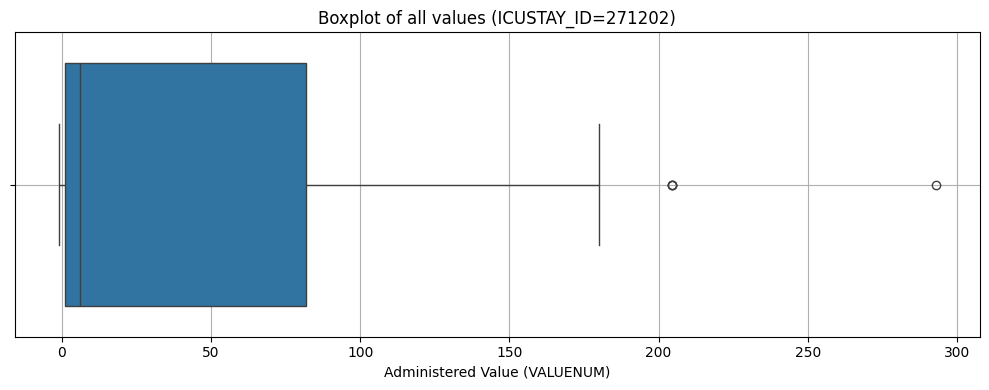

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "mimic-db-short/"

chart_df = pd.read_csv(
    data_path + "CHARTEVENTS.csv",
    usecols=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM'],
    low_memory=False
)

items_df = pd.read_csv(data_path + "D_ITEMS.csv", usecols=['ITEMID', 'LABEL'])

chart_df = chart_df.merge(items_df, on='ITEMID', how='left')

icustay_id = 271202
stay_df = chart_df[chart_df['ICUSTAY_ID'] == icustay_id].copy()

if stay_df.empty:
    print(f"No data found for ICUSTAY_ID = {icustay_id}. Choose another ID.")
else:
    stay_df['CHARTTIME'] = pd.to_datetime(stay_df['CHARTTIME'])
    t0 = stay_df['CHARTTIME'].min()
    stay_df['HOURS_FROM_START'] = (stay_df['CHARTTIME'] - t0).dt.total_seconds() / 3600
    stay_df['DAYS_FROM_START'] = stay_df['HOURS_FROM_START'] / 24

    scatter_df = stay_df.dropna(subset=['VALUENUM'])
    # NEW: Simple boxplot of all values (no separation by item)
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=scatter_df, x='VALUENUM')
    plt.title(f"Boxplot of all values (ICUSTAY_ID={icustay_id})")
    plt.xlabel("Administered Value (VALUENUM)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We identified the 10 most frequent `LABEL`s (medical items) and created a boxplot for each, allowing us to compare the distribution of values across different intervention types. This is particularly useful for spotting abnormal readings or highly variable administrations (e.g., fluids, medication dosages).

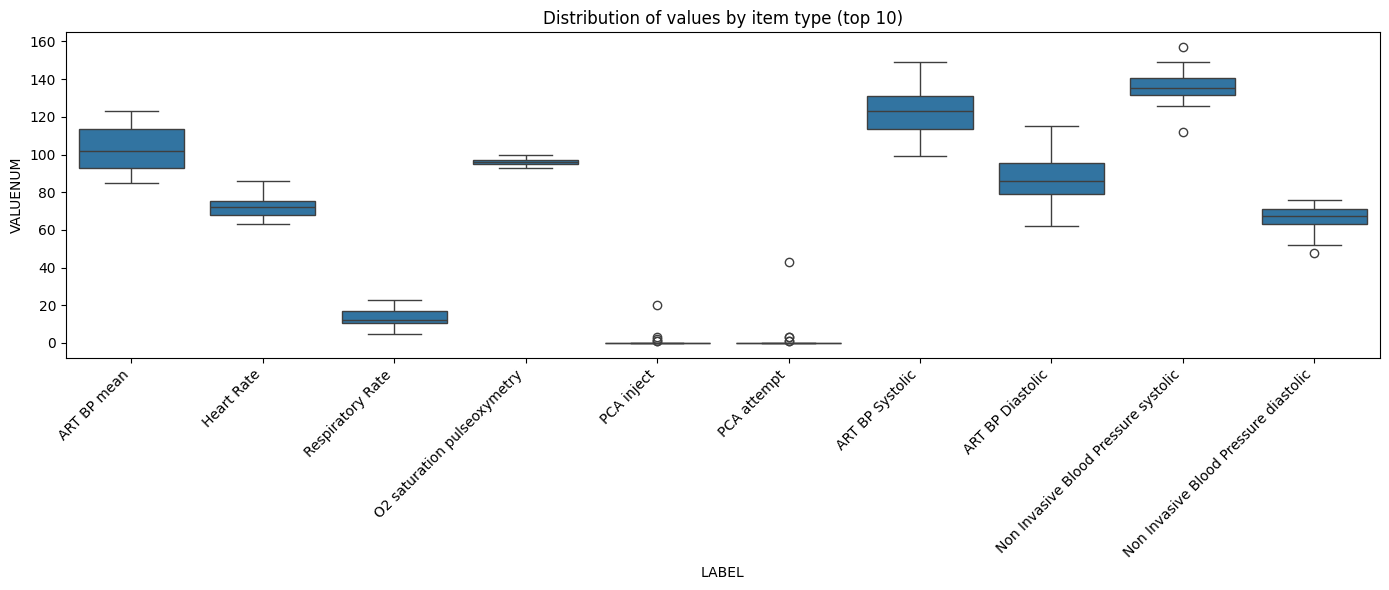

In [2]:
    top_items = scatter_df['LABEL'].value_counts().head(10).index
    box_df = scatter_df[scatter_df['LABEL'].isin(top_items)]

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=box_df, x='LABEL', y='VALUENUM')
    plt.xticks(rotation=45, ha='right')
    plt.title("Distribution of values by item type (top 10)")
    plt.tight_layout()
    plt.show()

To provide a focused view, we filtered and plotted a histogram of `VALUENUM` for entries labeled “Glucose”. This allows for a detailed inspection of blood glucose levels administered or recorded during the ICU stay, which is clinically relevant in many ICU scenarios.

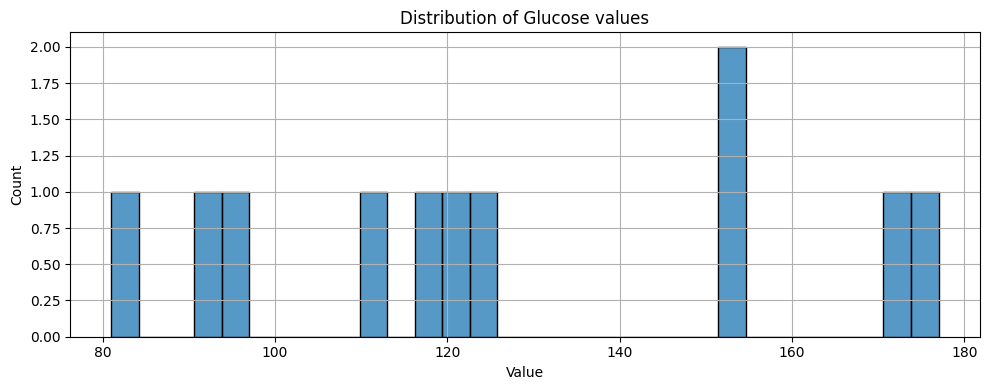

In [3]:
    # Histogram of a specific item (Glucose)
    item_label = 'Glucose'
    glucose_df = scatter_df[scatter_df['LABEL'].str.contains(item_label, case=False, na=False)]

    if glucose_df.empty:
        print(f"No data found with LABEL containing '{item_label}'.")
    else:
        plt.figure(figsize=(10, 4))
        sns.histplot(glucose_df['VALUENUM'], bins=30)
        plt.title(f"Distribution of {item_label} values")
        plt.xlabel("Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In addition to clinical event data, we analyzed the distribution of patient ages in the ICU population. Using `PATIENTS.csv` and `ADMISSIONS.csv`, we computed the age at the time of ICU admission by subtracting the date of birth (`DOB`) from the admission timestamp (`ADMITTIME`).

To ensure consistency and clinical relevance:
- We excluded entries with missing or clearly masked age values (e.g., `AGE > 115`).
- Age was calculated in years, with a valid range of approximately 0 to 115.

 A histogram with kernel density estimation (KDE) was plotted to show the distribution of patient ages. Most ICU admissions fell in the adult and elderly ranges, with a peak typically around 60–70 years.

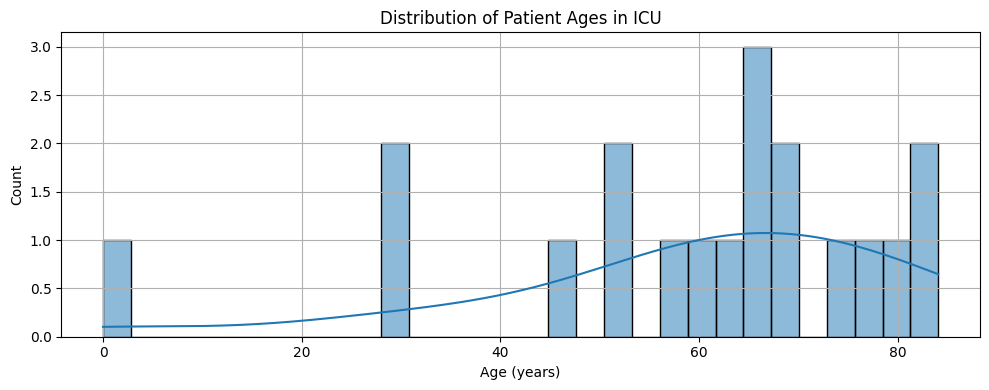

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "mimic-db-short/"

# Load data
icu_df = pd.read_csv(data_path + "ICUSTAYS.csv", usecols=['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'LOS'])
patients_df = pd.read_csv(data_path + "PATIENTS.csv", usecols=['SUBJECT_ID', 'DOB'])
admissions_df = pd.read_csv(data_path + "ADMISSIONS.csv", usecols=['SUBJECT_ID', 'ADMITTIME'])

# Convert to datetime
patients_df['DOB'] = pd.to_datetime(patients_df['DOB'], errors='coerce')
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'], errors='coerce')

# Filter out extreme DOBs (e.g., before 1900)
patients_df = patients_df[patients_df['DOB'] >= pd.Timestamp("1900-01-01")]

# Merge and calculate age
df = icu_df.merge(admissions_df, on='SUBJECT_ID', how='left')
df = df.merge(patients_df, on='SUBJECT_ID', how='left')

# Recalculate age safely
df = df.dropna(subset=['DOB', 'ADMITTIME'])
df['AGE'] = (df['ADMITTIME'] - df['DOB']).dt.total_seconds() / (365.25 * 24 * 3600)

# Filter reasonable ages
df = df[df['AGE'].between(0, 115)]

# Plot histogram
plt.figure(figsize=(10, 4))
sns.histplot(df['AGE'], bins=30, kde=True)
plt.title("Distribution of Patient Ages in ICU")
plt.xlabel("Age (years)")
plt.grid(True)
plt.tight_layout()
plt.show()


A complementary boxplot was generated to highlight outliers and the interquartile range (IQR) of ages. This helps identify whether the ICU cohort skews older or has a wide age spread.

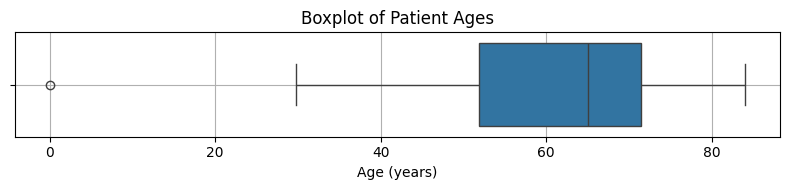

In [5]:
# Plot boxplot
plt.figure(figsize=(8, 2))
sns.boxplot(x=df['AGE'])
plt.title("Boxplot of Patient Ages")
plt.xlabel("Age (years)")
plt.grid(True)
plt.tight_layout()
plt.show()

Understanding the age distribution was crucial, as age is a significant predictor for ICU risk stratification and outcome models.

## **3.** Feature Engeneering

### Base ICUSTAY, ADMISSION, PATIENTS Table

 **1. ICU Stay Identifiers**  
- ICUSTAY_ID - Unique ICU admission identifier  
- SUBJECT_ID - Unique patient identifier  
- HADM_ID - Unique hospital admission identifier  

 **2. Target Variable**  
- ICU_LOS_DAYS (from LOS) - Length of ICU stay in days  

 **3. ICU Characteristics**  
- FIRST_CAREUNIT - Initial ICU unit type (e.g., MICU, SICU)  
- LAST_CAREUNIT - Final ICU unit before discharge  
- ICU_INTIME - ICU admission timestamp  
- ICU_OUTTIME - ICU discharge timestamp  

 **4. Patient Demographics**  
- GENDER - Patient's sex (M/F)  
- PATIENT_DIED (from EXPIRE_FLAG) - Mortality flag (0=survived)  
- DOB - Date of birth  

 **5. Hospital Admission Details**  
- ADMISSION_TYPE - Emergency/elective/etc. 
- ADMISSION_LOCATION - Where was the admission 
- INSURANCE - Medicare/private/etc.  
- ETHNICITY - Patient's ethnicity  
- MARITAL_STATUS/RELIGION - Demographic details  

 **6. Derived Column**  
- AGE_AT_ICU_ADMISSION - Computed age in years (using ICU_INTIME - DOB), filtered to adults (18-80)  

**Creation Process:**
1. Joined ICUSTAYS, PATIENTS, and ADMISSIONS tables  
2. Filtered to:  
   - Adult patients (18-80 years)  
   - Survivors (PATIENT_DIED=0)  
3. Dropped cached data to free memory  

In [5]:
print("📊 Creating base ICU dataset with patient demographics...")

base_icu_df = icustays_df.alias("icu") \
    .join(patients_df.alias("pat"), "SUBJECT_ID", "inner") \
    .join(admissions_df.alias("adm"), ["SUBJECT_ID", "HADM_ID"], "inner") \
    .select(
        col("icu.ICUSTAY_ID"),
        col("icu.SUBJECT_ID"), 
        col("icu.HADM_ID"),
        
        col("icu.LOS").alias("ICU_LOS_DAYS"),

        col("icu.FIRST_CAREUNIT"),
        col("icu.LAST_CAREUNIT"), 
        col("icu.INTIME").alias("ICU_INTIME"),
        col("icu.OUTTIME").alias("ICU_OUTTIME"),
        
        col("pat.GENDER"),
        col("pat.EXPIRE_FLAG").alias("PATIENT_DIED"),
        col("pat.DOB"),
        
        col("adm.ADMISSION_TYPE"),
        col("adm.ADMISSION_LOCATION"),
        col("adm.INSURANCE"),
        col("adm.ETHNICITY"),
        col("adm.MARITAL_STATUS"),
        col("adm.RELIGION")
    )

icustays_df.unpersist()

print("✅ Created base ICU dataset!")

📊 Creating base ICU dataset with patient demographics...
✅ Created base ICU dataset!


#### Removing Outliers

To ensure a clinically relevant and statistically robust analysis, we applied the following filters to the dataset:

1. Age Restriction (18–80 years): Pediatric patients (<18) and elderly populations (>65) were excluded due to differing physiological responses and treatment protocols.

2. Exclusion of Deceased Patients: Only survivors (PATIENT_DIED = 0) were retained to focus on ICU outcomes for living patients.

3. ICU Stay Duration (0–9.1 days): Based on exploratory data analysis (EDA), ICU stays beyond 9.1 days were identified as statistical outliers and removed to reduce bias from extreme cases.

4. Exclusion of cases with invalid timeframes.

These filters improve data quality by retaining only the most representative cases for analysis.

In [6]:
print(f"Number of rows before removing outlier cases: {base_icu_df.count()}")

base_icu_df = (base_icu_df
    .withColumn("AGE_AT_ICU_ADMISSION", 
                floor(datediff(col("ICU_INTIME"), col("DOB")) / 365.25))
    .filter(col("AGE_AT_ICU_ADMISSION").between(18, 65))      
    .filter(col("PATIENT_DIED") == 0)                         
    .filter(datediff(col("ICU_OUTTIME"), col("ICU_INTIME")) <= 9.1) 
    .filter(col("ICU_INTIME") < col("ICU_OUTTIME"))
)

print(f"Number of rows after removing outlier cases: {base_icu_df.count()}")

Number of rows before removing outlier cases: 20
Number of rows after removing outlier cases: 6


#### Categorical Feature Engineering  

**1. Binary Encodings**  
- GENDER_BINARY - Male (1) vs Female (0)  
- CAME_FROM_ER - Emergency Room admission (1) vs other sources (0)  
- HAS_INSURANCE - Medicare insurance (1) vs other types (0)  
- CHANGED_ICU_UNIT - ICU unit transfer occurred (1) vs no transfer (0)  

**2. Numeric Encodings**  
- ADMISSION_TYPE_ENCODED:  1=EMERGENCY  2=ELECTIVE  3=URGENT  0=Other  

- ETHNICITY_ENCODED:  1=WHITE  2=BLACK  3=HISPANIC  4=ASIAN  5=Other  

- MARITAL_STATUS_ENCODED:  1=MARRIED  2=SINGLE  3=DIVORCED  4=WIDOWED  5=SEPARATED  6=LIFE PARTNER  0=Other  

- RELIGION_ENCODED:  1=CATHOLIC  2=PROTESTANT  3=JEWISH  0=Other  

- FIRST_UNIT_ENCODED:  1=MICU (Medical ICU)  2=SICU (Surgical ICU)  3=CSRU (Cardiac Surgery)  4=CCU (Coronary Care)  5=TSICU (Trauma/Surgical)  0=Other  

**Creation Process**:  
1. Converted categorical variables to numeric representations  
2. Created binary flags for key clinical indicators  
3. Maintained consistent encoding schemes across similar variables  
4. Deleted the original columns

These engineered features enable machine learning algorithms to process categorical patient characteristics effectively.

In [7]:
print("📊 Engineering categorical features...")
base_icu_df = base_icu_df \
    .withColumn("GENDER_BINARY", when(col("GENDER") == "M", 1).otherwise(0)) \
    .withColumn("CAME_FROM_ER", when(col("ADMISSION_LOCATION").contains("EMERGENCY"), 1).otherwise(0)) \
    .withColumn("HAS_INSURANCE", when(col("INSURANCE") == "Medicare", 1).otherwise(0)) \
    .withColumn("ADMISSION_TYPE_ENCODED", 
                when(col("ADMISSION_TYPE") == "EMERGENCY", 1)
                .when(col("ADMISSION_TYPE") == "ELECTIVE", 2)
                .when(col("ADMISSION_TYPE") == "URGENT", 3)
                .otherwise(0)) \
    .withColumn("ETHNICITY_ENCODED",
                when(col("ETHNICITY").contains("WHITE"), 1)
                .when(col("ETHNICITY").contains("BLACK"), 2)
                .when(col("ETHNICITY").contains("HISPANIC"), 3)
                .when(col("ETHNICITY").contains("ASIAN"), 4)
                .otherwise(5)) \
    .withColumn("MARITAL_STATUS_ENCODED",
                when(col("MARITAL_STATUS") == "MARRIED", 1)
                .when(col("MARITAL_STATUS") == "SINGLE", 2)
                .when(col("MARITAL_STATUS") == "DIVORCED", 3)
                .when(col("MARITAL_STATUS") == "WIDOWED", 4)
                .when(col("MARITAL_STATUS") == "SEPARATED", 5)
                .when(col("MARITAL_STATUS") == "LIFE PARTNER", 6)
                .otherwise(0)) \
    .withColumn("RELIGION_ENCODED",
                when(col("RELIGION").contains("CATHOLIC"), 1)
                .when(col("RELIGION").contains("PROTESTANT"), 2)
                .when(col("RELIGION").contains("JEWISH"), 3)
                .otherwise(0)) \
    .withColumn("FIRST_UNIT_ENCODED", 
                when(col("FIRST_CAREUNIT") == "MICU", 1)
                .when(col("FIRST_CAREUNIT") == "SICU", 2)
                .when(col("FIRST_CAREUNIT") == "CSRU", 3)
                .when(col("FIRST_CAREUNIT") == "CCU", 4)
                .when(col("FIRST_CAREUNIT") == "TSICU", 5)
                .otherwise(0)) \
    .withColumn("CHANGED_ICU_UNIT", 
                when(col("FIRST_CAREUNIT") != col("LAST_CAREUNIT"), 1).otherwise(0))

print("📊 Dropping useless columns...")

drop_cols = [
    "FIRST_CAREUNIT",
    "LAST_CAREUNIT",
    "GENDER",
    "PATIENT_DIED",
    "DOB",
    "ADMISSION_TYPE",
    "ADMISSION_LOCATION",
    "INSURANCE",
    "ETHNICITY",
    "MARITAL_STATUS",
    "RELIGION"
]

base_icu_df = base_icu_df.drop(*drop_cols)

print("✅ Base ICU, ADMISSIONS, PATIENTS Table - Finalized")

📊 Engineering categorical features...
📊 Dropping useless columns...
✅ Base ICU, ADMISSIONS, PATIENTS Table - Finalized


Base ICUSTAY, ADMISSION, PATIENTS Table final schema:

**Core Identifiers**
- ICUSTAY_ID - Unique identifier for each ICU admission
- SUBJECT_ID - Unique patient identifier
- HADM_ID - Unique hospital admission identifier

**ICU Stay Metrics**
- ICU_LOS_DAYS - Length of stay in ICU (in days)
- ICU_INTIME - Timestamp of ICU admission
- ICU_OUTTIME - Timestamp of ICU discharge

**Patient Demographics**
- AGE_AT_ICU_ADMISSION - Patient age at ICU admission (years)
- GENDER_BINARY - Gender encoded as binary (1=Male, 0=Female)

**Admission Characteristics**
- CAME_FROM_ER - Binary flag for ER origin (1=Yes, 0=No)
- HAS_INSURANCE - Insurance status (1=Medicare, 0=Other)
- ADMISSION_TYPE_ENCODED - Encoded admission type
**Demographic Encodings**
- ETHNICITY_ENCODED - Numeric ethnicity classification
- MARITAL_STATUS_ENCODED - Numeric marital status
- RELIGION_ENCODED - Numeric religious affiliation

**ICU Unit Information**
- FIRST_UNIT_ENCODED - Numeric first unit type
- CHANGED_ICU_UNIT - Flag for unit transfers

This schema represents the complete feature set derived from joining and processing the core MIMIC-III tables (ICUSTAYS, PATIENTS, and ADMISSIONS), with all categorical variables appropriately encoded for analytical use. The dataset contains both raw temporal data (timestamps) and derived features.

In [8]:
icu_stay_ids = base_icu_df.select("ICUSTAY_ID").distinct()
icu_stay_ids.cache()

hadm_ids = base_icu_df.select("HADM_ID").distinct()
hadm_ids.cache()

DataFrame[HADM_ID: int]

### Clinical Events (CHARTEVENTS) Table

**Features Processing Pipeline:**

**1. Initial Filtering & Time Window Selection**
- Extracted key measurement data: ICUSTAY_ID, ITEMID, numeric values (VALUENUM) and timestamps (CHARTTIME)
- Applied three-way joining to:
  - Filter to only ICU stays in our base table
  - Incorporate ICU admission timestamps
- Implemented strict quality filters:
  - Removed records with null measurement values or timestamps
  - Restricted to measurements taken within the **first 24 hours** of ICU admission (using ICU_INTIME)
- Cached the resulting dataset for efficient downstream processing

2. **Category Enrichment**
   - Joined with D_ITEMS table to add CATEGORY information
   - Cached the enriched dataset for multiple uses

3. **Top Category Analysis**
   - Identified top 7 most frequent measurement categories
   - Filtered out null categories
   - Created dataset containing only measurements from top categories

4. **Statistical Aggregation**
   - Generated per-patient statistics for each measurement category:
     - Sum of all values (`_sum` suffix)
     - Count of measurements (`_count` suffix)
   - Filled null values with 0 for consistent analysis
   - Cleaned up cached DataFrames to free memory

**Output Schema:**
The final dataFrame contains:
- ICUSTAY_ID as the primary key
- For each of the top 7 measurement categories:
  - [CATEGORY]_sum - Sum of all measurements in this category
  - [CATEGORY]_count - Number of measurements in this category

This processing creates a feature-rich dataset where each ICU stay has aggregated statistics about the clinical measurements taken during their stay, organized by measurement category. The output is optimized for subsequent machine learning or analytical applications.

In [9]:
chartevents_filtered = chartevents_df.select(
    "ICUSTAY_ID", "ITEMID", "VALUENUM", "CHARTTIME"
).join(
    icu_stay_ids, "ICUSTAY_ID", "inner"
).join(
    base_icu_df.select("ICUSTAY_ID", "ICU_INTIME"), "ICUSTAY_ID", "inner"
).filter(
    (col("VALUENUM").isNotNull()) & 
    (col("CHARTTIME").isNotNull()) &
    col("CHARTTIME").between(
        col("ICU_INTIME"), 
        col("ICU_INTIME") + expr("INTERVAL 24 HOURS")
    )
).cache()


chartevents_with_categories = chartevents_filtered.join(
    d_items_df.select("ITEMID", "CATEGORY"), "ITEMID", "left"
).cache()


top_categories = chartevents_with_categories.groupBy("CATEGORY").agg(
    count("*").alias("count")
).orderBy(
    col("count").desc()
).limit(7).select("CATEGORY").collect()

top_categories = [cat for cat in [row["CATEGORY"] for row in top_categories] if cat != None  ]

chartevents_top_categories = chartevents_with_categories.filter(
    col("CATEGORY").isin(top_categories)
).cache()

patient_category_stats = chartevents_top_categories.groupBy("ICUSTAY_ID").pivot(
    "CATEGORY", top_categories
).agg(
    sql_sum("VALUENUM").alias("_sum"), 
    count("VALUENUM").alias("_count")
) 


chartevents_filtered.unpersist()
chartevents_with_categories.unpersist()
chartevents_top_categories.unpersist()

print("✅ Clinical Events Table - Finalized")

25/06/07 19:06:01 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
25/06/07 19:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1149.0 KiB
25/06/07 19:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1157.1 KiB
25/06/07 19:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1174.5 KiB


✅ Clinical Events Table - Finalized


### Laboratorial Events (LABEVENTS) Table

**Features Processing Pipeline**

**1. Initial Filtering & Extended Time Window Selection**
- Extracted key lab test data: HADM_ID, ITEMID, numeric values (VALUENUM) and timestamps (CHARTTIME)
- Applied three-way joining to:
  - Filter to only hospital admissions in our base table
  - Incorporate ICU admission timestamps (ICU_INTIME)
- Implemented strict quality filters:
  - Removed records with null lab values or timestamps
  - Expanded window to include tests from **6 hours before to 24 hours after** ICU admission
- Cached the resulting dataset for efficient downstream processing

**2. Category Enrichment**
- Joined with D_LABITEMS table to add test CATEGORY information
- Maintained the enriched dataset for multiple transformation steps

**3. Top Category Analysis**
- Identified top 7 most frequent lab test categories
- Filtered to include only these clinically significant categories
- Created optimized dataset focused on top categories

**4. Dual-Metric Statistical Aggregation**
- Generated comprehensive per-admission statistics:
  - Sum of all test values (using `_sum` suffix)
  - Count of tests performed (using `_count` suffix)
- Executed parallel pivot operations to maintain metric clarity

**Output Schema:**
The final DataFrame contains:
- HADM_ID as the primary key
- For each of the top 7 lab test categories:
  - [CATEGORY]_sum - Sum of all test values in category
  - [CATEGORY]_count - Number of tests performed in category


This processing creates a temporally-aware lab dataset where each hospital admission has an aggregated test results from the critical 30-hour window around ICU admission. The pre-ICU window provides offers a complete picture of patient lab status during transition to intensive care. Besides that, the data set provides insights of both magnitude and frequency metrics for each test category, having numerical features.

In [ ]:
labevents_filtered = labevents_df \
    .select(
        "HADM_ID",
        "ITEMID",
        col("VALUENUM").cast("double").alias("VALUENUM"),
        col("CHARTTIME").cast("timestamp").alias("CHARTTIME")
    ) \
    .join(hadm_ids, "HADM_ID", "inner") \
    .join(
        base_icu_df.select("HADM_ID", "ICU_INTIME"),
        "HADM_ID", "inner"
    ) \
    .filter(
        col("VALUENUM").isNotNull()
    ) \
    .filter(col("CHARTTIME").isNotNull()) \
    .filter(
        col("CHARTTIME").between(
            col("ICU_INTIME") - expr("INTERVAL 6 HOURS"),
            col("ICU_INTIME") + expr("INTERVAL 24 HOURS")
        )
    ) \
    .cache()

labevents_with_categories = labevents_filtered \
    .join(d_labitems_df.select("ITEMID", "CATEGORY"), "ITEMID", "left")

top_lab_categories = labevents_with_categories \
    .groupBy("CATEGORY") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(7) \
    .select("CATEGORY") \
    .collect()
top_lab_categories = [row["CATEGORY"] for row in top_lab_categories]

labevents_top_categories = labevents_with_categories.filter(
    col("CATEGORY").isin(top_lab_categories)
)

patient_lab_category_stats = labevents_top_categories.groupBy("HADM_ID", "CATEGORY") \
    .agg(
        F.sum(F.col("VALUENUM")).alias("sum_val"),
        F.count(F.lit(1)).alias("count_val")
    )

sum_pivot = patient_lab_category_stats.groupBy("HADM_ID") \
    .pivot("CATEGORY", top_lab_categories) \
    .sum("sum_val")

count_pivot = patient_lab_category_stats.groupBy("HADM_ID") \
    .pivot("CATEGORY", top_lab_categories) \
    .sum("count_val")

for category in top_lab_categories:
    count_pivot = count_pivot.withColumnRenamed(
        category, f"{category}_count"
    )
    sum_pivot = sum_pivot.withColumnRenamed(
        category, f"{category}_sum"
    )

final_lab_stats = sum_pivot.join(count_pivot, "HADM_ID", "inner")

print("✅ Laboratorial Events Table - Finalized")

25/06/07 19:06:03 WARN DAGScheduler: Broadcasting large task binary with size 1052.2 KiB
25/06/07 19:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1147.4 KiB
25/06/07 19:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB


✅ Laboratorial Events Table - Finalized


### DIAGNOSIS Table

**Features Processing Pipeline**

**1. ICD-9 Code Classification**
- Created mapping function that:
  - Handles both numeric and alphanumeric codes (V-codes, E-codes)
  - Classifies each code into 20 clinically meaningful chapters:
    - 1-17: Standard ICD-9 ranges (Infectious to Injury)
    - 18: Supplemental (V-codes)
    - 19: External Injury (E-codes) 
    - 0/20: Unknown/Other categories

**2. Top 3 Diagnosis Selection**
- Used window functions to:
  - Partition by hospital admission (HADM_ID)
  - Order by diagnosis sequence number (SEQ_NUM)
  - Select the first 3 diagnoses for each admission
  - Cached results for efficient processing

**3. Diagnosis Chapter Encoding**
- Applied UDF to convert ICD-9 codes to chapter numbers
- Created new column DISEASE_CHAPTER with encoded values

**4. Table Construction**
- Generated two feature types:
  1. **Top 3 Diagnoses**:
     - Pivoted to create columns for primary, secondary, and tertiary diagnoses
     - Cast as integer types for modeling
     - Filled missing values with -1
  2. **Diagnosis Count**:
     - Calculated total number of diagnoses per admission
     - Joined with top 3 diagnoses


**Output Schema:**
The final DataFrame contains:
- HADM_ID as the primary key
- PRIMARY_DIAGNOSIS - Most relevant diagnose
- SECONDARY_DIAGNOSIS - Second most relevant diagnose
- TERTIARY_DIAGNOSIS - Third most relevant diagnose
- TOTAL_DIAGNOSIS - Total amount of diagnoses the patient has

**Clinical Value:**

This processing transforms raw ICD-9 diagnoses into clinically meaningful features by classifying codes into 20 disease chapters while preserving diagnosis priority. It captures both specific conditions (through top 3 encoded diagnoses) and general comorbidity patterns (via total diagnosis count), using -1 for missing values. The resulting numerical features are immediately usable for comorbidity analysis, risk stratification, outcome prediction, and resource utilization studies, providing a compact yet information-rich representation of patient diagnoses for analytical applications.

In [11]:
def icd9_to_chapter(code):
    code_str = str(code).strip()
    
    if code_str.startswith('V'):
        return 18 #'Supplemental'
    
    if code_str.startswith('E'):
        return 19 #'External_Injury'
    
    try:
        numeric_part = code_str.split('.')[0] if '.' in code_str else code_str
        code_num = float(numeric_part[:3])
    except:
        return 0 #'Unknown'
    
    if 1 <= code_num <= 139: return 1 #'Infectious'
    elif 140 <= code_num <= 239: return 2 # 'Neoplasms'
    elif 240 <= code_num <= 279: return 3 #'Endocrine'
    elif 280 <= code_num <= 289: return 4 #'Blood'
    elif 290 <= code_num <= 319: return 5 #'Mental'
    elif 320 <= code_num <= 389: return 6 #'Nervous'
    elif 390 <= code_num <= 459: return 7 #'Circulatory'
    elif 460 <= code_num <= 519: return 8 #'Respiratory'
    elif 520 <= code_num <= 579: return 9 #'Digestive'
    elif 580 <= code_num <= 629: return 10 #'Genitourinary'
    elif 630 <= code_num <= 679: return 11 #'Pregnancy'
    elif 680 <= code_num <= 709: return 12 #'Skin'
    elif 710 <= code_num <= 739: return 13 #'Musculoskeletal'
    elif 740 <= code_num <= 759: return 14 #'Congenital'
    elif 760 <= code_num <= 779: return 15 #'Perinatal'
    elif 780 <= code_num <= 799: return 16 #'Ill-defined'
    elif 800 <= code_num <= 999: return 17 #'Injury'
    else: return 20 #'Other' 

In [12]:
window_spec = Window.partitionBy("HADM_ID").orderBy("SEQ_NUM")

top_3_filtered = diagnoses_df \
    .withColumn("row_num", row_number().over(window_spec)) \
    .filter(col("row_num") <= 3) \
    .cache()

icd9_chapter_udf = udf(icd9_to_chapter, IntegerType())

top_3_encoded = top_3_filtered.withColumn(
    "DISEASE_CHAPTER", 
    icd9_chapter_udf(col("ICD9_CODE"))
)

diagnosis_count = diagnoses_df.groupBy("HADM_ID").count().withColumnRenamed("count", "TOTAL_DIAGNOSES")

diagnoses_df.unpersist()

diagnosis_features = top_3_encoded \
    .groupBy("HADM_ID") \
    .pivot("row_num", [1, 2, 3]) \
    .agg(first("DISEASE_CHAPTER")) \
    .select(
        "HADM_ID",
        col("1").alias("PRIMARY_DIAGNOSIS").cast(IntegerType()),
        col("2").alias("SECONDARY_DIAGNOSIS").cast(IntegerType()),
        col("3").alias("TERTIARY_DIAGNOSIS").cast(IntegerType())
    ) \
    .join(diagnosis_count, "HADM_ID", "left")


diagnosis_features = diagnosis_features.fillna(-1, subset=[
    "PRIMARY_DIAGNOSIS",
    "SECONDARY_DIAGNOSIS",
    "TERTIARY_DIAGNOSIS"
])


print("✅ Diagnosis Table - Finalized")

✅ Diagnosis Table - Finalized


### Joining All Tables

Finally, the final modeling dataset was done by joining all feature tables (base table, clinical events, laboratorial results, and diagnoses) while excluding identifier and timestamp columns. The code performs left joins to preserve all ICU stays and lastly, cleans up by unpersisting intermediate tables.

In [13]:
print("📊 Joining all features from all tables...")

exclude_columns = {"ICUSTAY_ID", "HADM_ID", "SUBJECT_ID", "ICU_INTIME", "ICU_OUTTIME"}

modeling_dataset = base_icu_df \
    .join(patient_category_stats, "ICUSTAY_ID", "left") \
    .join(final_lab_stats, "HADM_ID", "left") \
    .join(diagnosis_features, "HADM_ID", "left") \
    .select(*[name for name in base_icu_df \
        .join(patient_category_stats, "ICUSTAY_ID", "left") \
        .join(final_lab_stats, "HADM_ID", "left") \
        .join(diagnosis_features, "HADM_ID", "left") \
        .columns if name not in exclude_columns])

base_icu_df.unpersist()
patient_category_stats.unpersist()
final_lab_stats.unpersist()
diagnosis_features.unpersist()

print(f"✅ Final table containing all features created with {modeling_dataset.count()} records and {len(modeling_dataset.columns)} features.")

📊 Joining all features from all tables...
✅ Final table containing all features created with 6 records and 33 features.


## **4.** Data Processing

### Missing Values

Our null handling carefully distinguishes between missing tests and zero results. For `_count` columns (test frequency), nulls become 0, correctly indicating no tests were performed. For `_sum` columns (test values), we use -1 for nulls to distinguish true zero results from missing data. This preserves critical clinical distinctions: a zero result differs meaningfully from an untested patient.

We retain all ICU stays because test availability varies by clinical need - some patients naturally won't receive certain tests based on their condition. This approach maintains dataset completeness while accurately representing both test presence/absence and actual results. The -1 placeholder prevents algorithms from misinterpreting missing data as zero-value results, which could distort predictive models. We validate this choice by showing the first 5 records and final dimensions.

In [14]:
print("📊 Filling NULL entries...")

count_columns = [c for c in modeling_dataset.columns if c.endswith('_count')]
for column in count_columns:
    modeling_dataset = modeling_dataset.withColumn(column, when(col(column).isNull(), 0).otherwise(col(column)))

sum_columns = [c for c in modeling_dataset.columns if c.endswith('_sum')]
for column in sum_columns:
    modeling_dataset = modeling_dataset.withColumn(column, when(col(column).isNull(), -1).otherwise(col(column)))

print("✅ NULL entries filled!")

📊 Filling NULL entries...
✅ NULL entries filled!


In [15]:
if modeling_dataset.na.drop().count() < modeling_dataset.count():
    print("❌ Dataset still contains NULL entries.")
    null_counts = modeling_dataset.select(
        [sum(col(c).isNull().cast("int")).alias(c) for c in modeling_dataset.columns]
    ).collect()[0]
    null_counts_dict = {col: null_counts[col] for col in modeling_dataset.columns if null_counts[col]>0}
    print(null_counts_dict)
else:
    print("✅ Dataset doesn't contain NULL entries.")

25/06/07 19:06:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/06/07 19:06:09 WARN DAGScheduler: Broadcasting large task binary with size 1548.3 KiB


✅ Dataset doesn't contain NULL entries.


### Scaling

**Pipeline:**
1. **Column Selection**: Identifies all `_sum` columns (aggregated clinical measurements) for normalization
2. **Vector Assembly**: Combines selected features into a single vector column for efficient processing
3. **Standard Scaling**: Applies Z-score normalization (mean=0, std=1) to ensure equal feature weighting
4. **Column Reconstruction**: Splits scaled features back to original column structure while maintaining naming

**Technical Implementation:**
- Uses Spark ML pipelines for atomic transformation
- Preserves invalid/missing values (handleInvalid="keep")
- Maintains original dataset structure after processing
- Cleans up temporary processing columns

**Output Validation:**
- Confirms count of scaled columns

This standardization ensures all continuous features contribute equally to machine learning models while preserving the dataset's interpretability and structure. The process handles edge cases (no `_sum` columns) gracefully.

In [16]:
print("📊 Applying StandardScaling to _sum columns...")
std_columns = [c for c in modeling_dataset.columns if c.endswith('_sum')]

if std_columns:
    assembler = VectorAssembler(
        inputCols=std_columns,
        outputCol="features_to_scale",
        handleInvalid="keep"
    )
    
    scaler = StandardScaler(
        inputCol="features_to_scale",
        outputCol="scaled_features"
    )
    
    pipeline = Pipeline(stages=[assembler, scaler])
    
    scaler_model = pipeline.fit(modeling_dataset)
    scaled_data = scaler_model.transform(modeling_dataset)
    
    scaled_data = scaled_data.withColumn("scaled_array", vector_to_array("scaled_features"))
    
    for i, col_name in enumerate(std_columns):
        scaled_data = scaled_data.withColumn(
            col_name,
            scaled_data["scaled_array"][i]
        )
    
    modeling_dataset = scaled_data.drop("features_to_scale", "scaled_features", "scaled_array")
    
    print(f"✅ Scaled {len(std_columns)} _sum columns")
else:
    print("⚠️ No _sum columns found to scale")

📊 Applying StandardScaling to _sum columns...


25/06/07 19:06:11 WARN DAGScheduler: Broadcasting large task binary with size 1433.2 KiB


✅ Scaled 9 _sum columns


The same pipeline was applied, using MinMax scaling (0-10 range) instead to `_count` columns, which track test/measurement frequencies. Unlike our StandardScaler approach for `_sum` values, MinMax better preserves the clinical interpretation of count data by maintaining the absolute zero baseline (where zero clearly indicates no tests performed). The 0-10 bound:
- Prevents extreme values from dominating models
- Maintains intuitive interpretation (5 = midpoint frequency)
- Allows algorithms to properly weight frequently ordered tests versus rare ones.

This scaling choice reflects that count variables have different statistical properties than continuous lab values.

In [17]:
print("📊 Applying MinMaxScaling to _count columns...")
minmax_columns = [c for c in modeling_dataset.columns if c.endswith('_count')]

if minmax_columns:
    assembler = VectorAssembler(
        inputCols=minmax_columns,
        outputCol="features_to_scale",
        handleInvalid="keep"
    )
    
    scaler = MinMaxScaler(
        inputCol="features_to_scale",
        outputCol="scaled_features",
        min=0,  
        max=10   
    )
    
    pipeline = Pipeline(stages=[assembler, scaler])
    
    scaler_model = pipeline.fit(modeling_dataset)
    scaled_data = scaler_model.transform(modeling_dataset)
    
    scaled_data = scaled_data.withColumn("scaled_array", vector_to_array("scaled_features"))
    
    for i, col_name in enumerate(minmax_columns):
        scaled_data = scaled_data.withColumn(
            col_name,
            scaled_data["scaled_array"][i]
        )

    modeling_dataset = scaled_data.drop("features_to_scale", "scaled_features", "scaled_array")
    
    print(f"✅ Scaled {len(minmax_columns)} _count columns using MinMax scaling")
else:
    print("⚠️ No _count columns found to scale")
    

print("✅ Data set ready for Machine Learning!")

📊 Applying MinMaxScaling to _count columns...


25/06/07 19:06:13 WARN DAGScheduler: Broadcasting large task binary with size 1437.7 KiB


✅ Scaled 9 _count columns using MinMax scaling
✅ Data set ready for Machine Learning!


## **5.** Model Training & Validation

### Data Splitting

The dataset is split into:
- 90% for training
- 10% for testing

This separation ensures that the final evaluation is performed on completely unseen data, providing an unbiased estimate of model performance.


Then, VectorAssembler is used to combine features (all columns except ICU_LOS_DAYS) into a single vector required by Spark ML models.

In [18]:
print("📊 Creating train/test split...")
train_data, test_data = modeling_dataset.randomSplit([0.8, 0.2], seed=1)

print("✅ Data split completed.")
print(f"   🚆 Training samples: {train_data.count()}")
print(f"   🧪 Test samples: {test_data.count()}")

feature_columns = [col for col in modeling_dataset.columns if col != 'ICU_LOS_DAYS']
print("Feature columns:", feature_columns)
target_column = 'ICU_LOS_DAYS'
print("Target column:", target_column)

feature_assembler = VectorAssembler(
    inputCols=feature_columns,  
    outputCol="features"   
)

📊 Creating train/test split...
✅ Data split completed.


25/06/07 19:06:17 WARN DAGScheduler: Broadcasting large task binary with size 1627.8 KiB


   🚆 Training samples: 5


25/06/07 19:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1627.8 KiB


   🧪 Test samples: 1
Feature columns: ['AGE_AT_ICU_ADMISSION', 'GENDER_BINARY', 'CAME_FROM_ER', 'HAS_INSURANCE', 'ADMISSION_TYPE_ENCODED', 'ETHNICITY_ENCODED', 'MARITAL_STATUS_ENCODED', 'RELIGION_ENCODED', 'FIRST_UNIT_ENCODED', 'CHANGED_ICU_UNIT', 'Routine Vital Signs__sum', 'Routine Vital Signs__count', 'Respiratory__sum', 'Respiratory__count', 'Hemodynamics__sum', 'Hemodynamics__count', 'Labs__sum', 'Labs__count', 'Alarms__sum', 'Alarms__count', 'Pain/Sedation__sum', 'Pain/Sedation__count', 'Hematology_sum', 'Chemistry_sum', 'Blood Gas_sum', 'Hematology_count', 'Chemistry_count', 'Blood Gas_count', 'PRIMARY_DIAGNOSIS', 'SECONDARY_DIAGNOSIS', 'TERTIARY_DIAGNOSIS', 'TOTAL_DIAGNOSES']
Target column: ICU_LOS_DAYS


### Regression Evaluation Metrics 

Next we configurate the evaluation metrics:

- **RMSE** (Root Mean Squared Error): Measures the average magnitude of prediction errors, giving higher weight to larger errors. Lower is better.
- **MAE** (Mean Absolute Error): Measures the average absolute difference between predicted and actual values. Easier to interpret; lower is better.
- **R²** (Coefficient of Determination): Indicates how well the model explains the variance in the target variable. Ranges from 0 to 1 (higher is better).

In [19]:
print("📊Setting up evaluation metrics...")

rmse_evaluator = RegressionEvaluator(
    labelCol=target_column, 
    predictionCol="prediction", 
    metricName="rmse"
)

mae_evaluator = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction", 
    metricName="mae"
)

r2_evaluator = RegressionEvaluator(
    labelCol=target_column,
    predictionCol="prediction",
    metricName="r2"
)

def evaluate_model(model_name, predictions):
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)
    
    print(f"\n📊 {model_name.upper()} Evaluation Metrics:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   R²: {r2:.4f}")
    
    return rmse, mae, r2

print("✅ Evaluation metrics configured")

📊Setting up evaluation metrics...
✅ Evaluation metrics configured


### Model Configuration

Three regression models are initialized:
- Random Forest Regressor
- Gradient Boosted Trees Regressor
- Linear Regression

Each model is associated with a parameter grid for tuning its hyperparameters.

In [20]:
print("📊Setting up evaluation models...")

models = {
    'RandomForest': RandomForestRegressor(
        featuresCol="features", 
        labelCol=target_column,
        predictionCol="prediction"
    ),
    'GradientBoostedTrees': GBTRegressor(
        featuresCol="features",
        labelCol=target_column,
        predictionCol="prediction"
    ),
    'LinearRegression': LinearRegression(
        featuresCol="features",
        labelCol=target_column,
        predictionCol="prediction"
    )
}

param_grids = {
    'RandomForest': ParamGridBuilder() \
        .addGrid(models['RandomForest'].numTrees, [10, 20, 30]) \
        .addGrid(models['RandomForest'].maxDepth, [5, 10, 15]) \
        .build(),
    'GradientBoostedTrees': ParamGridBuilder() \
        .addGrid(models['GradientBoostedTrees'].maxIter, [10, 20]) \
        .addGrid(models['GradientBoostedTrees'].maxDepth, [5, 10]) \
        .build(),
    'LinearRegression': ParamGridBuilder() \
        .addGrid(models['LinearRegression'].regParam, [0.01, 0.1, 1.0]) \
        .addGrid(models['LinearRegression'].elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()
}

print("✅ Models configured.")

📊Setting up evaluation models...
✅ Models configured.


### Cross Validation

A 5-fold cross-validation is used to select the best model and hyperparameters on the training data only. During this step, the 90% training data is split internally into 5 folds:
- 4 folds are used for training - 72%
- 1 fold is used for validation - 18%

This is repeated 5 times, rotating the validation fold each time.

Although CrossValidator handles splitting internally, we still perform an initial train/test split to keep a separate 20% test set that remains untouched during training or tuning. This ensures reliable performance evaluation.

In [ ]:
print("🏋️ Training models with 5-fold cross validation...")

results = {}

for model_name in models:
    print(f"\n🔍 Training {model_name.upper()} model...")
    
    pipeline = Pipeline(stages=[feature_assembler, models[model_name]])
    
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grids[model_name],
        evaluator=rmse_evaluator,
        numFolds=5,
        seed=42,
        collectSubModels=False
    )
    
    cv_model = cv.fit(train_data)
    
    best_model = cv_model.bestModel
    
    test_predictions = best_model.transform(test_data)
    
    test_rmse = rmse_evaluator.evaluate(test_predictions)
    test_mae = mae_evaluator.evaluate(test_predictions)
    test_r2 = r2_evaluator.evaluate(test_predictions)
    
    results[model_name] = {
        'model': best_model,
        'test_metrics': {
            'rmse': test_rmse,
            'mae': test_mae,
            'r2': test_r2
        },
        'cv_avg_metrics': cv_model.avgMetrics
    }

🏋️ Training models with 5-fold cross validation...

🔍 Training RANDOMFOREST model...


25/06/07 19:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1629.7 KiB
25/06/07 19:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1694.2 KiB
25/06/07 19:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1694.2 KiB
25/06/07 19:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
25/06/07 19:06:24 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 3 (= number of training instances)
25/06/07 19:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1697.5 KiB
25/06/07 19:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1699.3 KiB
25/06/07 19:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1699.7 KiB
25/06/07 19:06:25 WARN DAGScheduler: Broadcasting large task binary with size 1699.2 KiB
25/06/07 19:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1629.6 KiB
25/06/07 19:06:29 WARN DAGScheduler: Broadcasting large task binary with size 

IllegalArgumentException: requirement failed: Nothing has been added to this summarizer.

25/06/07 19:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1699.6 KiB
25/06/07 19:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1702.6 KiB
25/06/07 19:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1703.7 KiB
25/06/07 19:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1702.6 KiB
25/06/07 19:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1693.2 KiB
25/06/07 19:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1694.3 KiB
25/06/07 19:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.2 KiB
25/06/07 19:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.2 KiB
25/06/07 19:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.0 KiB
25/06/07 19:06:59 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 5 (= number of training instances)
25/06/07 19:06:59 WARN DAGScheduler: Broadcasting large task binary with size 

### Model Evaluation

After cross-validation identifies the best hyperparameter combination, the resulting model is evaluated on the unseen test set using RMSE, MAE, and R² to measure its predictive accuracy and generalization performance.

In [ ]:
print("\n📋 FINAL RESULTS SUMMARY:")
for model_name, result in results.items():
    print(f"\n⭐ {model_name.upper()}:")
    print(f"   Test RMSE: {result['test_metrics']['rmse']:.4f}")
    print(f"   Test MAE: {result['test_metrics']['mae']:.4f}")
    print(f"   Test R²: {result['test_metrics']['r2']:.4f}")
    print(f"   5-fold Avg RMSE: {np.mean(result['cv_avg_metrics']):.4f}")

## **6.** Performance Profiling

por fazer

## **7.** Interpretation of Results

por fazer